1) Для реализованной модели градиентного бустинга построить графики зависимости ошибки от количества деревьев в ансамбле и от максимальной глубины деревьев. Сделать выводы о зависимости ошибки от этих параметров.<br>
2) * Модифицировать реализованный алгоритм градиентного бустинга, чтобы получился стохастический градиентный бустинг. Размер подвыборки принять равным 0.5. Сравнить на одном графике кривые изменения ошибки на тестовой выборке в зависимости от числа итераций.<br>
3) *Оптимизировать процесс обучения градиентного бустинга, чтобы он занимал меньше времени.<br>

In [2]:
from sklearn import model_selection
from sklearn.tree import DecisionTreeRegressor
from sklearn.datasets import load_diabetes
import matplotlib.pyplot as plt
import numpy as np

In [3]:
X, y = load_diabetes(return_X_y=True)
X.shape, y.shape

((442, 10), (442,))

In [4]:
X_train, X_test, y_train, y_test = model_selection.train_test_split(X, y, test_size=0.25)


In [5]:
from time import time


def gb_predict(X, trees_list, eta):
#     t1 = time() 
    # Реализуемый алгоритм градиентного бустинга будет инициализироваться нулевыми значениями,
    # поэтому все деревья из списка trees_list уже являются дополнительными и при предсказании
    # прибавляются с шагом eta
       
    ####### каждый следующий цикл был увеличен из-за x in X, каждый шаг был немного дольше предыдущего,
    ####### потому что X каждый раз становился немного больше
    predictions = np.array(sum([eta * alg.predict(X) for alg in trees_list]))
#     t2 = time() 
#     print('gb_predict', t2-t1)
    return predictions

In [6]:
def mean_squared_error(y_real, prediction):
    return (sum((y_real - prediction)**2)) / len(y_real)

In [7]:
def residual(y, z):
    return - (z - y)

In [8]:
def gb_fit(n_trees, max_depth, X_train, X_test, y_train, y_test, eta):
    
    # Деревья будем записывать в список
    trees = []
    
    # Будем записывать ошибки на обучающей и тестовой выборке на каждой итерации в список
    train_errors = []
    test_errors = []
    
    for i in range(n_trees):
        tree = DecisionTreeRegressor(max_depth=max_depth, random_state=42)

        # первый алгоритм просто обучаем на выборке и добавляем в список
        if len(trees) == 0:
            # обучаем первое дерево на обучающей выборке
            tree.fit(X_train, y_train)
            
            train_errors.append(mean_squared_error(y_train, gb_predict(X_train, trees, eta)))
            test_errors.append(mean_squared_error(y_test, gb_predict(X_test, trees, eta)))
        else:
            # Получим ответы на текущей композиции
            target = gb_predict(X_train, trees, eta)
            
            # алгоритмы начиная со второго обучаем на сдвиг
            tree.fit(X_train, residual(y_train, target))
            
            train_errors.append(mean_squared_error(y_train, gb_predict(X_train, trees, eta)))
            test_errors.append(mean_squared_error(y_test, gb_predict(X_test, trees, eta)))

        trees.append(tree)
        
    return trees, train_errors, test_errors

In [9]:
import random
def sgb_fit(n_trees, max_depth, X_train, X_test, y_train, y_test, eta, percentage=0.5):
    
    # Деревья будем записывать в список
    trees = []
    
    # Будем записывать ошибки на обучающей и тестовой выборке на каждой итерации в список
    train_errors = []
    test_errors = []
    
    for i in range(n_trees):
        tree = DecisionTreeRegressor(max_depth=max_depth, random_state=42)
        
        
        ###### выбираю случайные объекты чтобы использовать их как выборку для стохастического градиентного спуска
        indicies_gb_fit = np.random.choice(X_train.shape[0], int(X_train.shape[0] * percentage), replace=False)
        
        # первый алгоритм просто обучаем на выборке и добавляем в список
        if len(trees) == 0:
            # обучаем первое дерево на обучающей выборке
            tree.fit(X_train[indicies_gb_fit], y_train[indicies_gb_fit])
            
            train_errors.append(mean_squared_error(y_train, gb_predict(X_train, trees, eta)))
            test_errors.append(mean_squared_error(y_test, gb_predict(X_test, trees, eta)))
        else:
            # Получим ответы на текущей композиции
            target = gb_predict(X_train[indicies_gb_fit], trees, eta)
            
            # алгоритмы начиная со второго обучаем на сдвиг
            tree.fit(X_train[indicies_gb_fit], residual(y_train[indicies_gb_fit], target))
            
            train_errors.append(mean_squared_error(y_train, gb_predict(X_train, trees, eta)))
            test_errors.append(mean_squared_error(y_test, gb_predict(X_test, trees, eta)))

        trees.append(tree)
        
    return trees, train_errors, test_errors

In [10]:
%%time
# Число деревьев в ансамбле
n_trees = 10

# Максимальная глубина деревьев
max_depth = 3

# Шаг
eta = 1

trees, train_errors, test_errors = gb_fit(n_trees, max_depth, X_train, X_test, y_train, y_test, eta)

Wall time: 19 ms


In [11]:
def evaluate_alg(X_train, X_test, y_train, y_test, trees, eta):
    train_prediction = gb_predict(X_train, trees, eta)

    print(f'Ошибка алгоритма из {n_trees} деревьев глубиной {max_depth} \
    с шагом {eta} на тренировочной выборке: {mean_squared_error(y_train, train_prediction)}')

    test_prediction = gb_predict(X_test, trees, eta)

    print(f'Ошибка алгоритма из {n_trees} деревьев глубиной {max_depth} \
    с шагом {eta} на тестовой выборке: {mean_squared_error(y_test, test_prediction)}')

In [12]:
evaluate_alg(X_train, X_test, y_train, y_test, trees, eta)

Ошибка алгоритма из 10 деревьев глубиной 3     с шагом 1 на тренировочной выборке: 1240.9733782772526
Ошибка алгоритма из 10 деревьев глубиной 3     с шагом 1 на тестовой выборке: 3845.915817642825


In [13]:
def get_error_plot(n_trees, train_err, test_err):
    plt.xlabel('Iteration number')
    plt.ylabel('MSE')
    plt.xlim(0, n_trees)
    plt.plot(list(range(n_trees)), train_err, label='train error')
    plt.plot(list(range(n_trees)), test_err, label='test error')
    plt.legend(loc='upper right')
    plt.show()

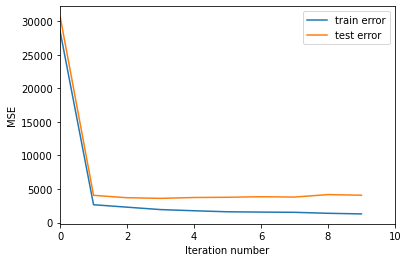

In [14]:
get_error_plot(n_trees, train_errors, test_errors)

In [15]:
%%time
eta = 0.1
n_trees = 100
max_depth = 5

trees, train_errors, test_errors = gb_fit(n_trees, max_depth, X_train, X_test, y_train, y_test, eta)

Wall time: 821 ms


In [16]:
%%time
eta = 0.1
n_trees = 100
max_depth = 5

trees, train_errors, test_errors = gb_fit(n_trees, max_depth, X_train, X_test, y_train, y_test, eta)

Wall time: 822 ms


In [17]:
evaluate_alg(X_train, X_test, y_train, y_test, trees, eta)

Ошибка алгоритма из 100 деревьев глубиной 5     с шагом 0.1 на тренировочной выборке: 108.758855396302
Ошибка алгоритма из 100 деревьев глубиной 5     с шагом 0.1 на тестовой выборке: 3826.767466848998


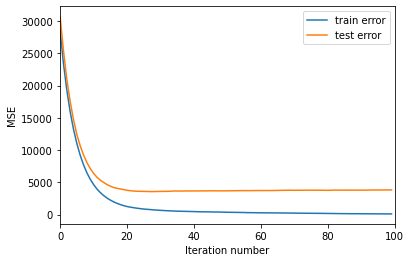

In [18]:
get_error_plot(n_trees, train_errors, test_errors)

In [19]:
%%time
eta = 0.19
n_trees = 100
max_depth = 5

trees, train_errors, test_errors = sgb_fit(n_trees, max_depth, X_train, X_test, y_train, y_test, eta)

Wall time: 769 ms


In [20]:
evaluate_alg(X_train, X_test, y_train, y_test, trees, eta)

Ошибка алгоритма из 100 деревьев глубиной 5     с шагом 0.19 на тренировочной выборке: 15.690024505564962
Ошибка алгоритма из 100 деревьев глубиной 5     с шагом 0.19 на тестовой выборке: 3924.250280364169


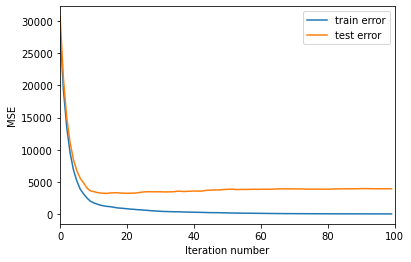

In [21]:
get_error_plot(n_trees, train_errors, test_errors)

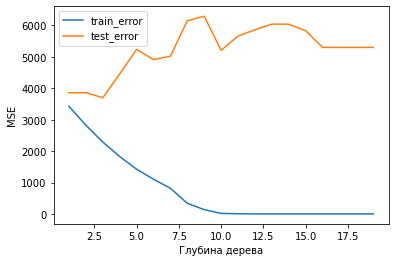

In [81]:
eta = 1
max_depths = range(1, 20, 1)
n_trees = 3

train_errors_depths = []
test_errors_depths = []

for max_depth in max_depths:
    _, train_errors, test_errors = gb_fit(n_trees, max_depth, X_train, X_test, y_train, y_test, eta)
    train_errors_depths.append(train_errors[-1])
    test_errors_depths.append(test_errors[-1])



plt.plot(max_depths, train_errors_depths, label='train_error')
plt.plot(max_depths, test_errors_depths, label='test_error')
plt.xlabel(f'Глубина дерева')
plt.ylabel('MSE')
plt.legend()

при большой глубине дерево начинает переобучаться, достаточно глубины 3, чтобы была максимальная эффективность

In [77]:
max_depths

range(1, 20)

In [41]:
train_errors

[28515.933534743202, 319.9160854335325, 16.693409590199863]

In [42]:
test_errors

[30740.063063063062, 5427.24112297768, 5206.6072422858515]

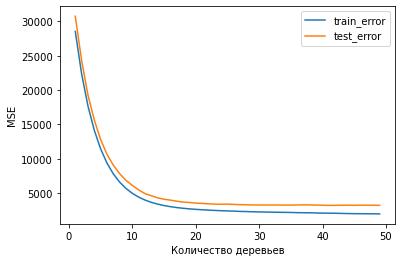

In [142]:
eta = 0.13
max_depths = 2
n_trees = range(1, 50, 1)

train_errors_depths = []
test_errors_depths = []

for each in n_trees:
    _, train_errors, test_errors = gb_fit(each, max_depth, X_train, X_test, y_train, y_test, eta)
    train_errors_depths.append(train_errors[-1])
    test_errors_depths.append(test_errors[-1])



plt.plot(n_trees, train_errors_depths, label='train_error')
plt.plot(n_trees, test_errors_depths, label='test_error')
plt.xlabel(f'Количество деревьев')
plt.ylabel('MSE')
plt.legend()
plt.show()

где-то на 10-11 дереве теряется эффективность обучения, следовательно стоит остановиться на этом значении.

In [153]:
eta = 0.2
n_trees = 100
max_depth = 3

_, train_errors_gb, test_errors_gb = gb_fit(n_trees, max_depth, X_train, X_test, y_train, y_test, eta)
_, train_errors_sgb, test_errors_sgb = sgb_fit(n_trees, max_depth, X_train, X_test, y_train, y_test, eta)


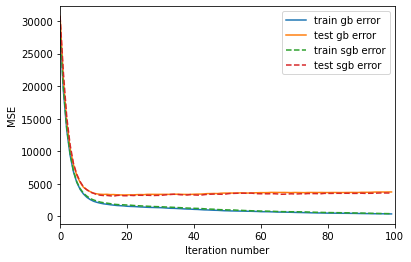

In [154]:
plt.xlabel('Iteration number')
plt.ylabel('MSE')
plt.xlim(0, n_trees)
plt.plot(list(range(n_trees)), train_errors_gb, label='train gb error')
plt.plot(list(range(n_trees)), test_errors_gb, label='test gb error')
plt.plot(list(range(n_trees)), train_errors_sgb, label='train sgb error', linestyle='--')
plt.plot(list(range(n_trees)), test_errors_sgb, label='test sgb error', linestyle='--')
plt.legend(loc='upper right')

plt.show()